<a href="https://colab.research.google.com/github/Shw-et-a/Melanoma_Detection/blob/main/shweta_upadhyay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing all the important Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Unzip the dataset
!unzip '/content/gdrive/MyDrive/CNN_assignment.zip' >/dev/null

#### A dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")


In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Creating a Dataset


In [6]:
# Parameters for the loader:
batch_size=32
img_height=180
img_width=180

#### Using 80% of the images for training and 20% for validation

In [7]:
# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
#Classes of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data visualization

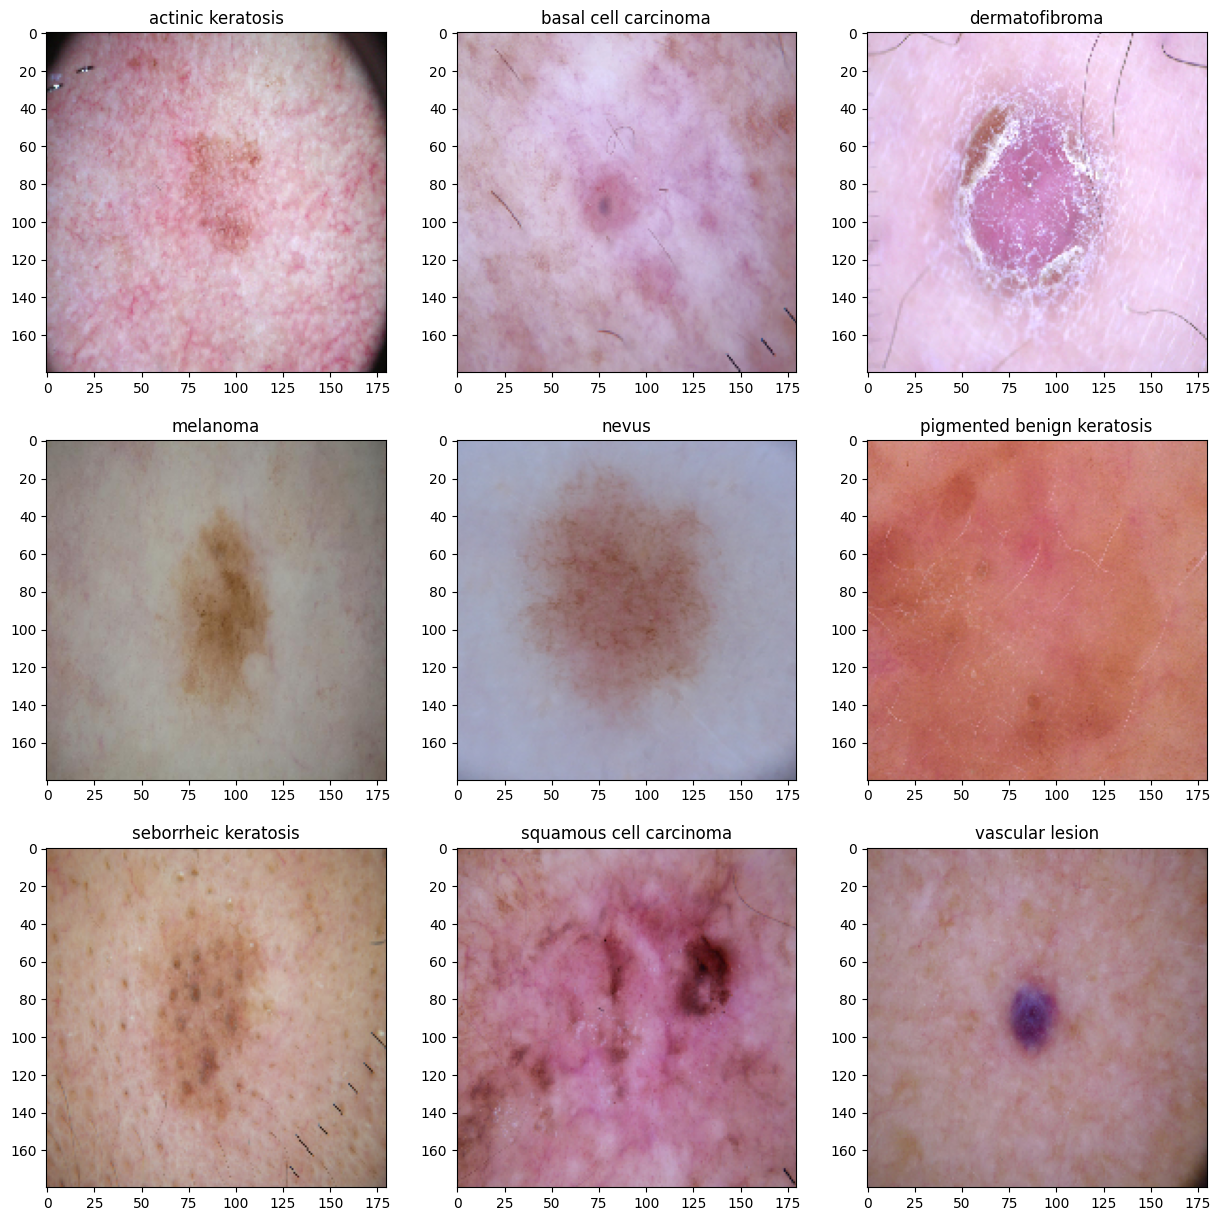

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

image_batch is a tensor of the form (32, 180, 180, 3). This is a stack of 32 images in the format 180x180x3 (the last dimension refers to the RGB color channels). label_batch is a tensor of the form (32,) , these are the labels corresponding to the 32 images.

Dataset.cache() keeps the images in memory after loading them from disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Creation

In [12]:
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model

In [13]:
#Adam optimization and categorical_crossentropy

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

Train the model

In [15]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
14/14 [==============================] - 22s 450ms/step - loss: 2.6193 - accuracy: 0.1790 - val_loss: 2.0414 - val_accuracy: 0.2058
Epoch 2/20
14/14 [==============================] - 1s 47ms/step - loss: 2.0631 - accuracy: 0.1946 - val_loss: 2.0356 - val_accuracy: 0.2058
Epoch 3/20
14/14 [==============================] - 1s 45ms/step - loss: 2.0222 - accuracy: 0.2394 - val_loss: 1.9874 - val_accuracy: 0.2774
Epoch 4/20
14/14 [==============================] - 1s 45ms/step - loss: 1.9204 - accuracy: 0.3110 - val_loss: 1.7828 - val_accuracy: 0.3110
Epoch 5/20
14/14 [==============================] - 1s 45ms/step - loss: 1.7718 - accuracy: 0.3490 - val_loss: 1.7423 - val_accuracy: 0.3848
Epoch 6/20
14/14 [==============================] - 1s 45ms/step - loss: 1.6250 - accuracy: 0.3915 - val_loss: 1.6946 - val_accuracy: 0.3893
Epoch 7/20
14/14 [==============================] - 1s 45ms/step - loss: 1.5788 - accuracy: 0.4564 - val_loss: 1.3840 - val_accuracy: 0.5168
Epoch 8/20


## Visualizing training results

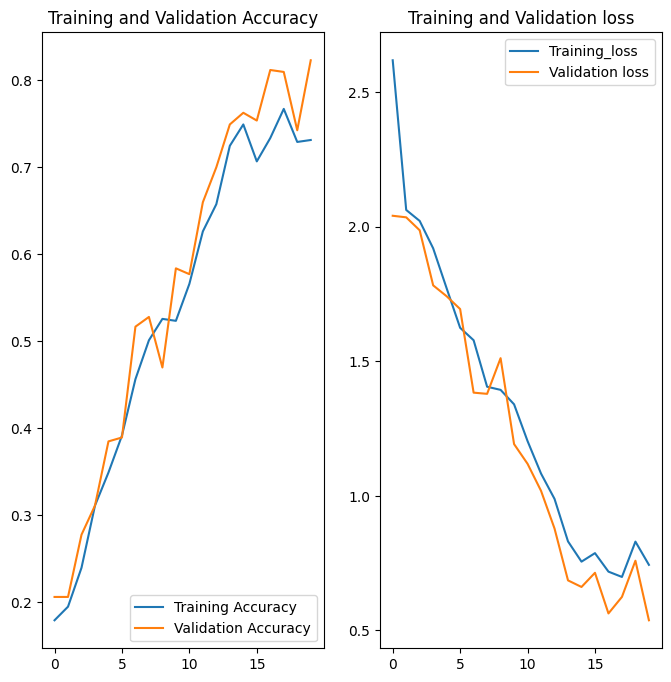

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training_loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

The model is overfitted. From the training and validation accuracy graph above, we can see that the difference between training accuracy and validation accuracy increases as the epoch increases.

In [17]:
# Data augmentation strategy.
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2),
                                         layers.experimental.preprocessing.RandomZoom(0.2),
                                         layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
])


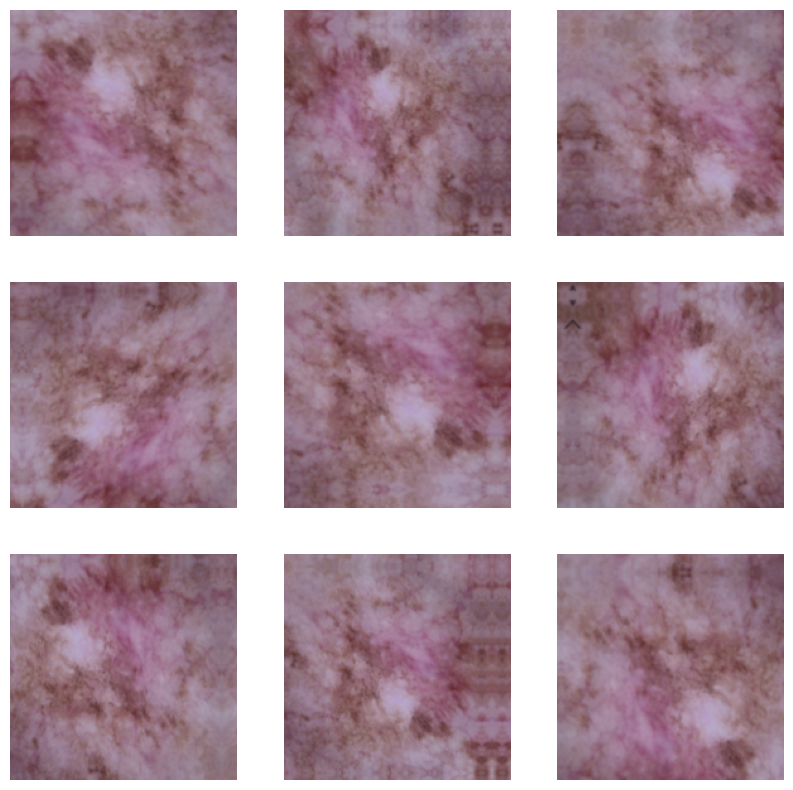

In [18]:
#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Model - 2 Creation

In [19]:
model2 = Sequential()

model2.add(data_augmentation)
model2.add(rescale)

In [20]:
#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

In [21]:
#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

In [22]:
#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

In [23]:
#Dropout layer
model2.add(layers.Dropout(0.25))


In [24]:
#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))


In [25]:
model2.add(layers.Flatten())

In [26]:
#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

model2.add(layers.Dense(128,activation='relu'))

In [27]:
#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))


In [28]:
#Dense Layer with softmax activation function.

model2.add(layers.Dense(len(class_names),activation='softmax'))


### Compiling the Model

In [29]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [30]:
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
14/14 [==============================] - 5s 85ms/step - loss: 2.8575 - accuracy: 0.1700 - val_loss: 2.0922 - val_accuracy: 0.1499
Epoch 2/20
14/14 [==============================] - 1s 71ms/step - loss: 2.1007 - accuracy: 0.1879 - val_loss: 2.1797 - val_accuracy: 0.1812
Epoch 3/20
14/14 [==============================] - 1s 82ms/step - loss: 2.0959 - accuracy: 0.1924 - val_loss: 2.1557 - val_accuracy: 0.2841
Epoch 4/20
14/14 [==============================] - 1s 72ms/step - loss: 2.0360 - accuracy: 0.2394 - val_loss: 1.9983 - val_accuracy: 0.3244
Epoch 5/20
14/14 [==============================] - 1s 84ms/step - loss: 1.9312 - accuracy: 0.2796 - val_loss: 1.9241 - val_accuracy: 0.2841
Epoch 6/20
14/14 [==============================] - 1s 85ms/step - loss: 1.9762 - accuracy: 0.2528 - val_loss: 1.8945 - val_accuracy: 0.3087
Epoch 7/20
14/14 [==============================] - 1s 70ms/step - loss: 1.8043 - accuracy: 0.3333 - val_loss: 1.8424 - val_accuracy: 0.3803
Epoch 8/20
14

## Visualizing model-2 Results

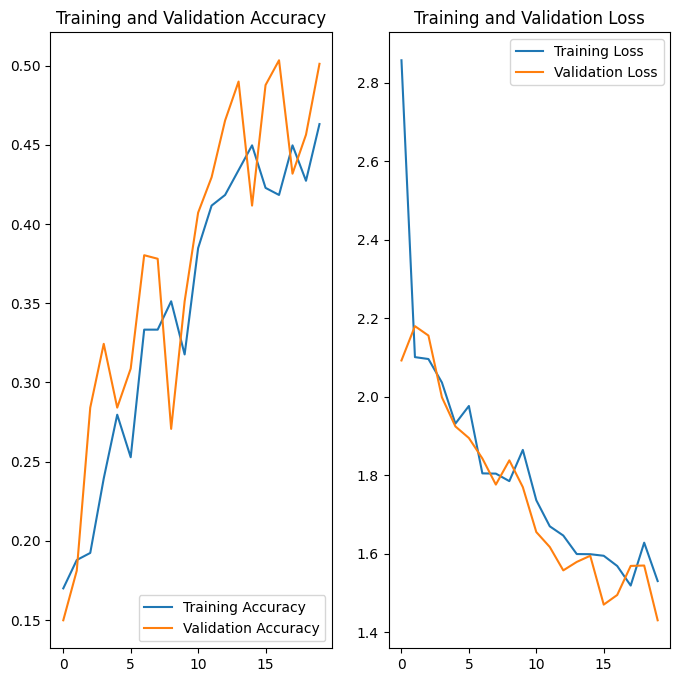

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Overfitting is reduced in Model-2
- But model performance is still not increased.


### Class Imbalance Detection

In [32]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,seborrheic keratosis,77
1,squamous cell carcinoma,181
2,pigmented benign keratosis,462
3,actinic keratosis,114
4,basal cell carcinoma,376
5,melanoma,438
6,dermatofibroma,95
7,vascular lesion,139
8,nevus,357


<Axes: xlabel='No. of Image', ylabel='Class'>

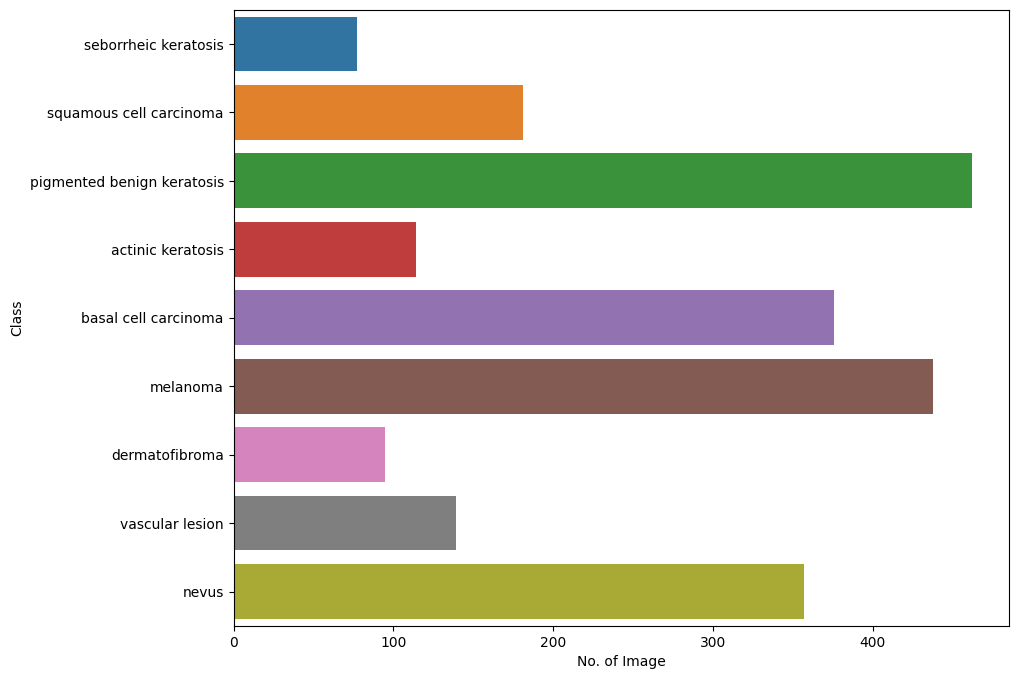

In [33]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

-Seborrheic keratosis has only 77 samples.

-pigmented benign keratosis (462 Samples), melanoma (438 Samples), basal cell carcinoma (376 Samples), and nevus (357 Samples) classes dominates the data in terms proportionate number of samples .

# Fixing Class Imbalance

Using python package Augmentor to add more samples.

In [34]:
!pip install Augmentor

In [35]:
# We are adding 500 samples per class to make sure that none of the classes are sparse.

path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79426667BB20>: 100%|██████████| 500/500 [00:25<00:00, 19.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79431834D810>: 100%|██████████| 500/500 [00:25<00:00, 19.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794266743B50>: 100%|██████████| 500/500 [00:22<00:00, 22.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7942664D39D0>: 100%|██████████| 500/500 [01:49<00:00,  4.55 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7942664DFF70>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7942664F3FD0>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x794266527CA0>: 100%|██████████| 500/500 [00:47<00:00, 10.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79426660D180>: 100%|██████████| 500/500 [00:19<00:00, 26.15 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794266743910>: 100%|██████████| 500/500 [00:21<00:00, 23.60 Samples/s]


In [36]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Checking the duistribution of augmentated data

In [37]:
#path_list
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [38]:
#lesion_list_new
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [41]:
#label count.
df2['Label'].value_counts()

seborrheic keratosis          500
squamous cell carcinoma       500
pigmented benign keratosis    500
actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
dermatofibroma                500
vascular lesion               500
nevus                         500
Name: Label, dtype: int64

500 images added to maintain class balance.

# Train the model on data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

In [43]:
# Creating a training dataset
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [44]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model - 3

In [45]:
model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))


In [46]:
# Compile Model
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [47]:
# Training Model-3
epochs = 30
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/30
169/169 [==============================] - 38s 185ms/step - loss: 2.4941 - accuracy: 0.1743 - val_loss: 7.7900 - val_accuracy: 0.1359
Epoch 2/30
169/169 [==============================] - 32s 184ms/step - loss: 2.0466 - accuracy: 0.2530 - val_loss: 2.2701 - val_accuracy: 0.1952
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.7748 - accuracy: 0.3181 - val_loss: 2.6516 - val_accuracy: 0.2554
Epoch 4/30
169/169 [==============================] - 32s 186ms/step - loss: 1.6290 - accuracy: 0.3802 - val_loss: 2.2452 - val_accuracy: 0.2264
Epoch 5/30
169/169 [==============================] - 33s 187ms/step - loss: 1.5043 - accuracy: 0.4171 - val_loss: 2.3280 - val_accuracy: 0.2918
Epoch 6/30
169/169 [==============================] - 31s 181ms/step - loss: 1.4188 - accuracy: 0.4599 - val_loss: 1.9847 - val_accuracy: 0.3237
Epoch 7/30
169/169 [==============================] - 31s 181ms/step - loss: 1.3317 - accuracy: 0.4987 - val_loss: 2.3602 - val_ac

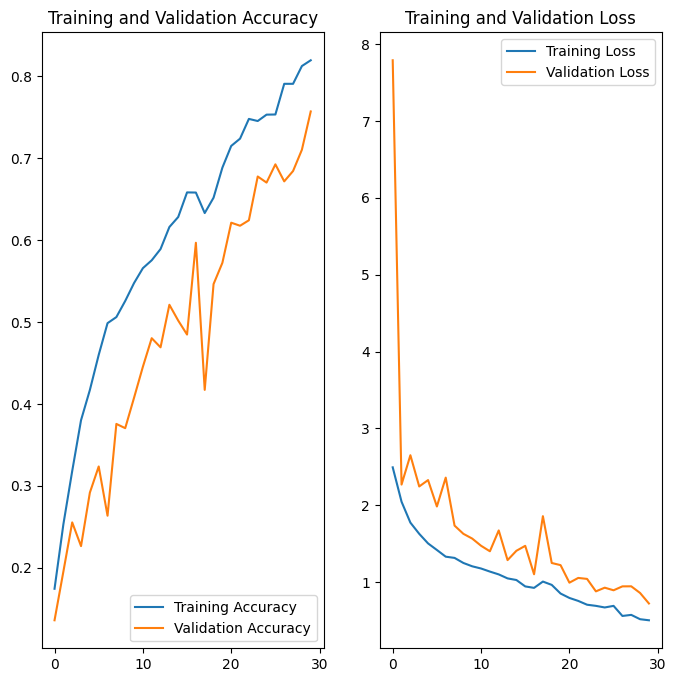

In [48]:
#Visualize the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



*   In Model-3 the training accuracy and validation accuracy increased.
*   Model is not overfitting.


*   Augmentation for class rebance helped in achieving best training and validation accuracy.




